<div style="text-align: center;">
  <div style="display: inline-block; min-width: 60%; font-weight: bold; font-size: 24px; color: white; background-color: blue; padding: 15px 20px; border: 2px solid white; border-radius: 8px;">
    Nanonets-OCR-s for Documents Parsing
  </div>
</div>

This notebook explores Nanonets-OCR-s, an advanced image-to-markdown OCR model developed by Nanonets. Unlike traditional OCR tools that simply extract plain text, Nanonets-OCR-s goes a step further by converting document content into richly structured Markdown, enabling more intelligent parsing and downstream use—particularly for Large Language Models (LLMs). With capabilities like LaTeX equation recognition, intelligent image descriptions, signature and watermark tagging, smart checkbox interpretation, and complex table extraction, this model is purpose-built to handle diverse and challenging document types with precision.

<br>
<img src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" alt="Hugging Face" width="20" style="vertical-align:middle;"/> : https://huggingface.co/nanonets/Nanonets-OCR-s

# **1. Install Libraries**

In [6]:
%%capture
! pip install markdown2
! pip install pdf2image
! apt-get update && apt-get install -y poppler-utils
! pip install tabulate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

# **2. Import Libraries**

In [9]:
import os
import base64
import logging
import time
from pathlib import Path
import pandas as pd
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from PIL import Image
import re

from IPython.display import display, HTML
import base64
import markdown
import markdown2

import io
from io import BytesIO, StringIO

import warnings
import sys
import contextlib

from transformers import AutoTokenizer, AutoProcessor, AutoModelForImageTextToText

# **3. Load Nanonets-OCR-s**

In [3]:
model_path = "nanonets/Nanonets-OCR-s"

model = AutoModelForImageTextToText.from_pretrained(
    model_path, 
    torch_dtype="auto", 
    device_map="auto", 
    #attn_implementation="flash_attention_2"
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path)
processor = AutoProcessor.from_pretrained(model_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


video_preprocessor_config.json: 0.00B [00:00, ?B/s]

# **4. Inference**

In [4]:
def ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=4096):
    prompt = """Extract the text from the above document as if you were reading it naturally. Return the tables in html format. Return the equations in LaTeX representation. If there is an image in the document and image caption is not present, add a small description of the image inside the <img></img> tag; otherwise, add the image caption inside <img></img>. Watermarks should be wrapped in brackets. Ex: <watermark>OFFICIAL COPY</watermark>. Page numbers should be wrapped in brackets. Ex: <page_number>14</page_number> or <page_number>9/22</page_number>. Prefer using ☐ and ☑ for check boxes."""
    image = Image.open(image_path)
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": [
            {"type": "image", "image": f"file://{image_path}"},
            {"type": "text", "text": prompt},
        ]},
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to(model.device)
    
    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return output_text[0]

In [10]:
def clean_markdown_table(md_table):
    """Clean and flatten markdown table headers and remove HTML/LaTeX."""
    md_table = re.sub(r'<br\s*/?>', ' ', md_table, flags=re.IGNORECASE)
    md_table = re.sub(r'\$+', '', md_table)
    
    lines = md_table.strip().split('\n')
    if len(lines) < 3:
        return None

    header_1 = lines[0].strip().strip('|').split('|')
    header_2 = lines[2].strip().strip('|').split('|') if lines[1].strip().startswith('|') else []

    # Merge multi-row headers if possible
    if header_2 and len(header_1) == len(header_2):
        headers = [f"{h1.strip()} {h2.strip()}".strip() for h1, h2 in zip(header_1, header_2)]
        data_start = 3
    else:
        headers = [h.strip() for h in header_1]
        data_start = 2

    # Extract the data rows
    data_rows = []
    for line in lines[data_start:]:
        if "|" not in line:
            continue
        row = [cell.strip() for cell in line.strip().strip('|').split('|')]
        if len(row) == len(headers):
            data_rows.append(row)

    if not data_rows:
        return None

    df = pd.DataFrame(data_rows, columns=headers)
    return df

def display_text_with_pdf_or_image_plain(raw_text, file_path, pdf_page=0, max_width=800):
    """
    Display image or PDF and extract markdown tables with complex headers,
    displaying them as clean Pandas DataFrames.
    """
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    # --- Display image or PDF ---
    try:
        if file_path.lower().endswith(".pdf"):
            images = convert_from_path(file_path, first_page=pdf_page + 1, last_page=pdf_page + 1)
            img = images[0].convert("RGB")
        else:
            img = Image.open(file_path).convert("RGB")

        w_percent = max_width / float(img.width)
        new_height = int(float(img.height) * w_percent)
        img = img.resize((max_width, new_height), Image.LANCZOS)

        buffer = BytesIO()
        img.save(buffer, format="JPEG", quality=70)
        img_data = base64.b64encode(buffer.getvalue()).decode()
        display(HTML(f"""
        <div style="text-align: center;">
            <img src="data:image/jpeg;base64,{img_data}" style="width: 100%; border: 1px solid #ccc;" />
        </div>
        """))
    except Exception as e:
        print(f"[Error displaying file]: {e}")

    # --- Extract Markdown tables ---
    markdown_tables = list(re.finditer(
        r"(\|.+\|\s*\n\|[-:| ]+\|\s*\n(?:\|.*\|\s*\n?)+)", raw_text
    ))

    last_end = 0
    for match in markdown_tables:
        text_before = raw_text[last_end:match.start()].strip()
        if text_before:
            print(text_before)
            print('-' * 40)

        table_text = match.group(0)
        df = clean_markdown_table(table_text)
        if df is not None:
            display(df)
        else:
            print("[Could not parse table]")
            print(table_text)

        last_end = match.end()

    # Print any text after last table
    remaining_text = raw_text[last_end:].strip()
    if remaining_text:
        print(remaining_text)

## **Example n°1**

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



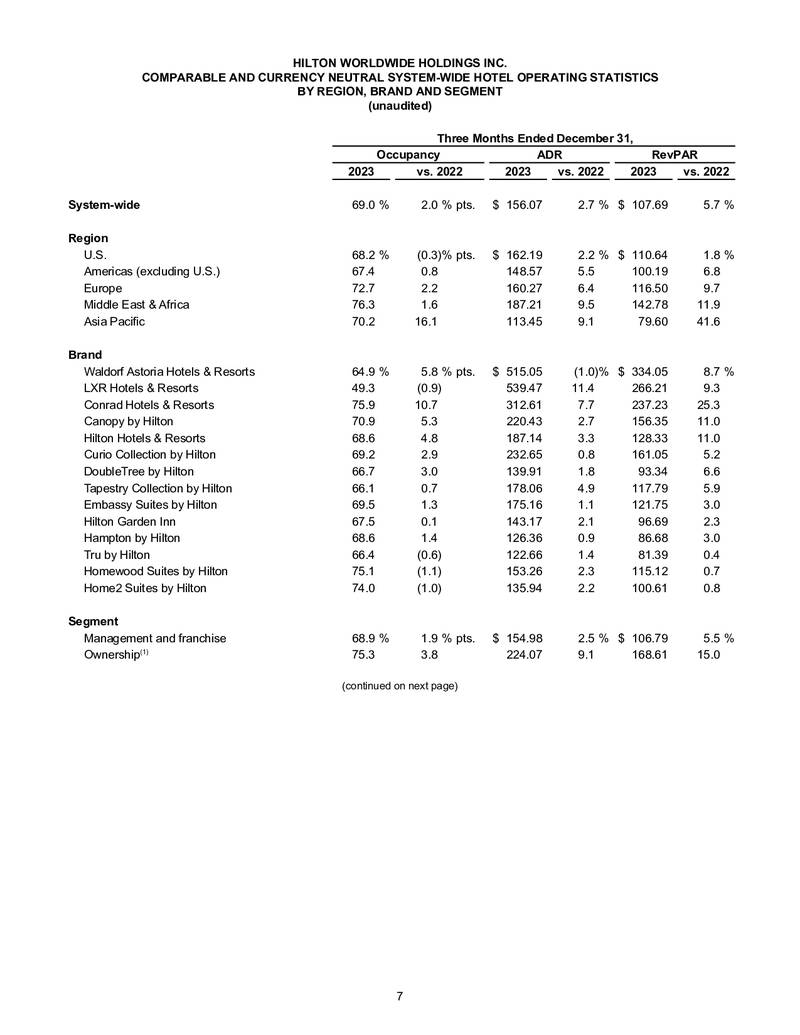

HILTON WORLDWIDE HOLDINGS INC.
COMPARABLE AND CURRENCY NEUTRAL SYSTEM-WIDE HOTEL OPERATING STATISTICS
BY REGION, BRAND AND SEGMENT
(unaudited)
----------------------------------------
[Could not parse table]
|  | Three Months Ended December 31, |
|---|---|
|  | Occupancy | ADR | RevPAR |
|  | 2023 vs. 2022 | 2023 vs. 2022 | 2023 vs. 2022 |
| **System-wide** | 69.0 % 2.0 % pts. $ 156.07 2.7 % $ 107.69 5.7 % |  |  |
| **Region** |  |  |  |
| U.S. | 68.2 % (0.3)% pts. $ 162.19 2.2 % $ 110.64 1.8 % |  |  |
| Americas (excluding U.S.) | 67.4 0.8 148.57 5.5 100.19 6.8 |  |  |
| Europe | 72.7 2.2 160.27 6.4 116.50 9.7 |  |  |
| Middle East & Africa | 76.3 1.6 187.21 9.5 142.78 11.9 |  |  |
| Asia Pacific | 70.2 16.1 113.45 9.1 79.60 41.6 |  |  |
| **Brand** |  |  |  |
| Waldorf Astoria Hotels & Resorts | 64.9 % 5.8 % pts. $ 515.05 (1.0)% $ 334.05 8.7 % |  |  |
| LXR Hotels & Resorts | 49.3 (0.9) 539.47 11.4 266.21 9.3 |  |  |
| Conrad Hotels & Resorts | 75.9 10.7 312.61 7.7 237.23 25.3 |  |  

In [11]:
image_path = "/teamspace/studios/this_studio/pdf_files_pages/q4-2023-earnings-release_page-0007.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)
display_text_with_pdf_or_image_plain(
    result,
    image_path
)

## **Example n°2**

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



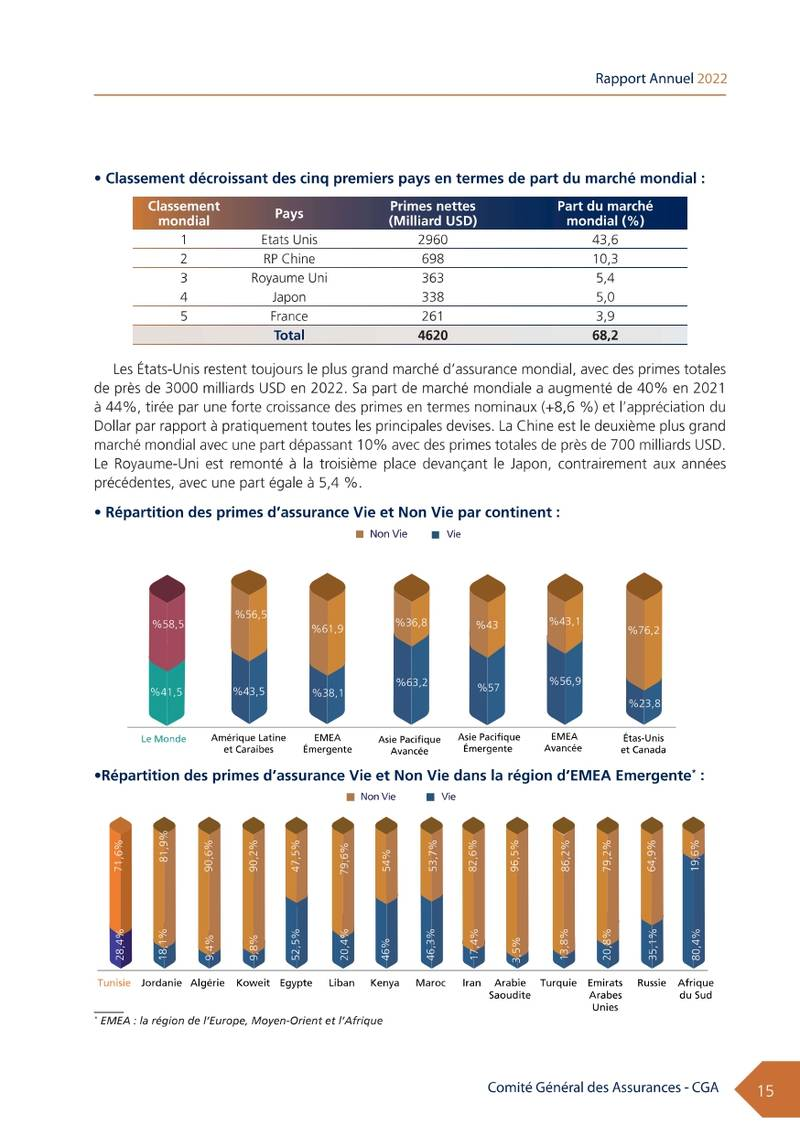

Rapport Annuel 2022

**• Classement décroissant des cinq premiers pays en termes de part du marché mondial :**

<table>
  <tr>
    <th>Classement mondial</th>
    <th>Pays</th>
    <th>Primes nettes (Milliard USD)</th>
    <th>Part du marché mondial (%)</th>
  </tr>
  <tr>
    <td>1</td>
    <td>États-Unis</td>
    <td>2960</td>
    <td>43,6</td>
  </tr>
  <tr>
    <td>2</td>
    <td>RP Chine</td>
    <td>698</td>
    <td>10,3</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Royaume Uni</td>
    <td>363</td>
    <td>5,4</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Japon</td>
    <td>338</td>
    <td>5,0</td>
  </tr>
  <tr>
    <td>5</td>
    <td>France</td>
    <td>261</td>
    <td>3,9</td>
  </tr>
  <tr>
    <td colspan="3"><strong>Total</strong></td>
    <td><strong>4620</strong></td>
    <td><strong>68,2</strong></td>
  </tr>
</table>

Les États-Unis restent toujours le plus grand marché d'assurance mondial, avec des primes totales de près de 3000 milliards USD en 2022. Sa part de marché mo

In [12]:
image_path = "/teamspace/studios/this_studio/pdf_files_pages/doc1.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)
display_text_with_pdf_or_image_plain(
    result,
    image_path
)

## **Example n°3**

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



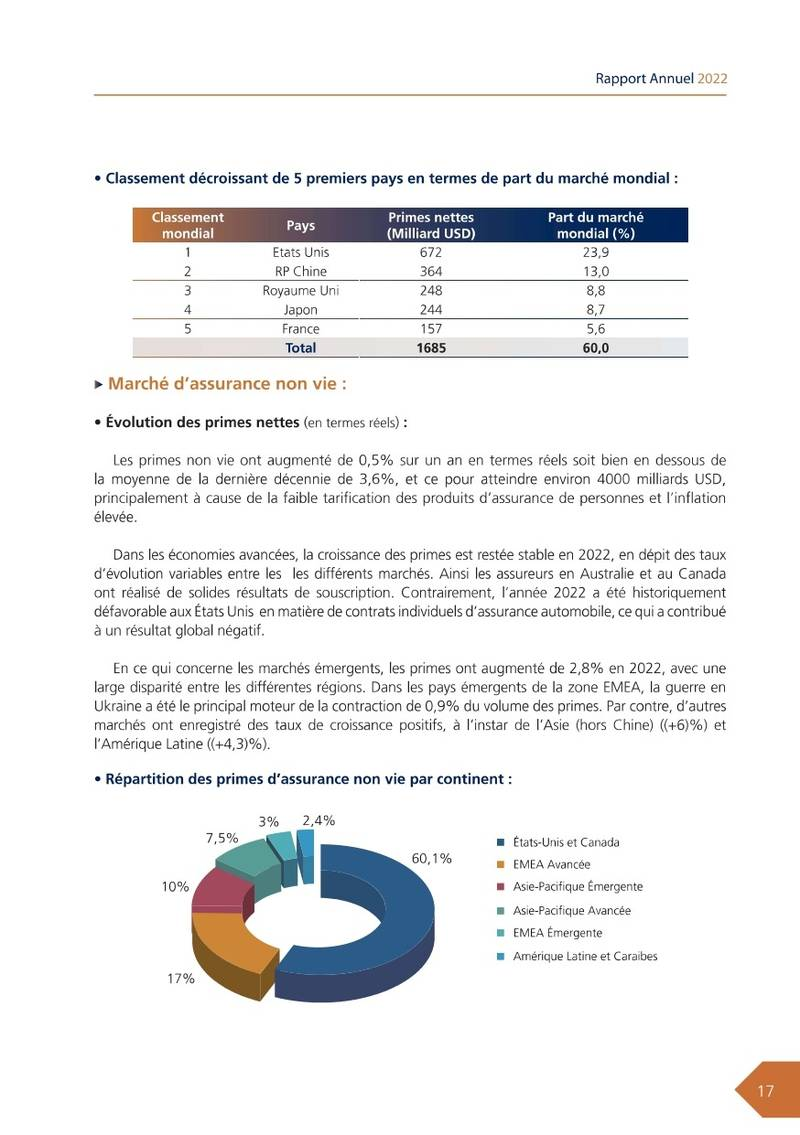

Rapport Annuel 2022

* **Classement décroissant de 5 premiers pays en termes de part du marché mondial :**

<table>
  <tr>
    <td>Classement mondial</td>
    <td>Pays</td>
    <td>Primes nettes (Milliard USD)</td>
    <td>Part du marché mondial (%)</td>
  </tr>
  <tr>
    <td>1</td>
    <td>États Unis</td>
    <td>672</td>
    <td>23,9</td>
  </tr>
  <tr>
    <td>2</td>
    <td>RP Chine</td>
    <td>364</td>
    <td>13,0</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Royaume Uni</td>
    <td>248</td>
    <td>8,8</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Japon</td>
    <td>244</td>
    <td>8,7</td>
  </tr>
  <tr>
    <td>5</td>
    <td>France</td>
    <td>157</td>
    <td>5,6</td>
  </tr>
  <tr>
    <td colspan="2"><strong>Total</strong></td>
    <td><strong>1685</strong></td>
    <td><strong>60,0</strong></td>
  </tr>
</table>

▶ **Marché d'assurance non vie :**

* **Évolution des primes nettes (en termes réels) :**

Les primes non vie ont augmenté de 0,5% sur un an en termes réels soit 

In [13]:
image_path = "/teamspace/studios/this_studio/pdf_files_pages/doc2.JPG"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)
display_text_with_pdf_or_image_plain(
    result,
    image_path
)

## **Example n°4**

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



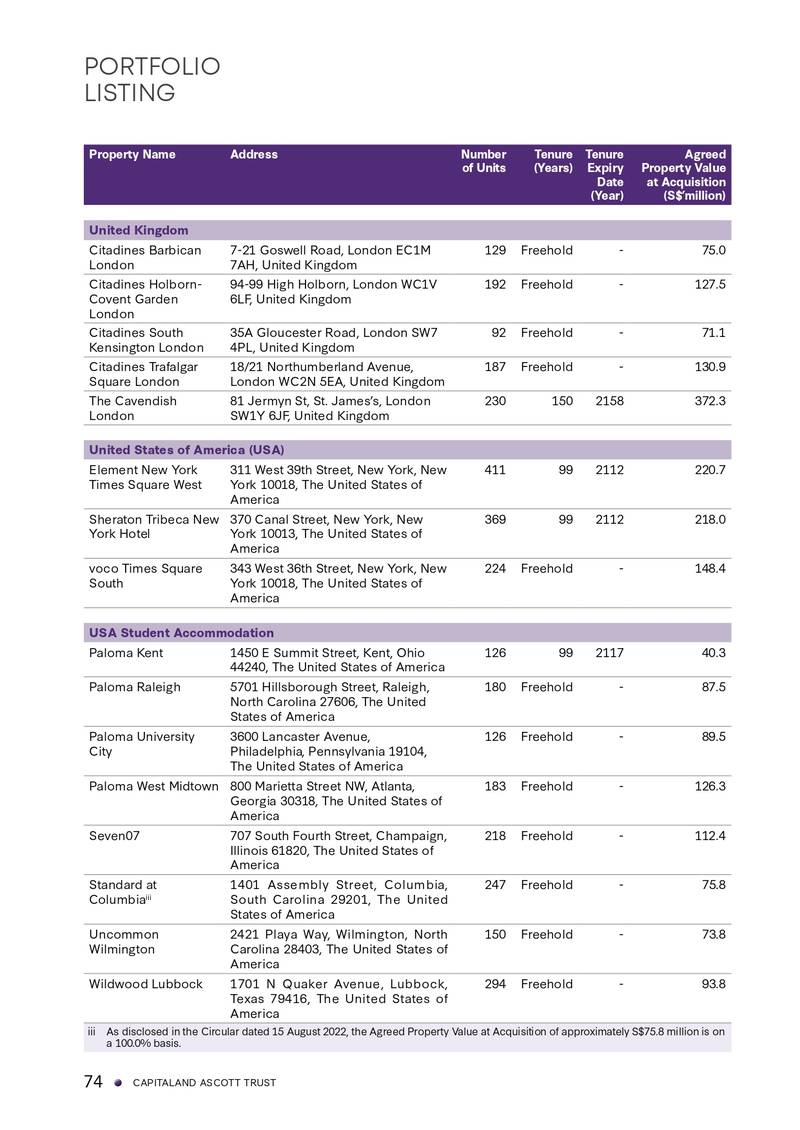

PORTFOLIO LISTING

<table>
  <tr>
    <th>Property Name</th>
    <th>Address</th>
    <th>Number of Units</th>
    <th>Tenure (Years)</th>
    <th>Tenure Expiry Date (Year)</th>
    <th>Agreed Property Value at Acquisition (S$'million)</th>
  </tr>
  <tr>
    <td colspan="6" style="background-color: #808080; color: white;">United Kingdom</td>
  </tr>
  <tr>
    <td>Citadines Barbican London</td>
    <td>7-21 Goswell Road, London EC1M 7AH, United Kingdom</td>
    <td>129</td>
    <td>Freehold</td>
    <td>-</td>
    <td>75.0</td>
  </tr>
  <tr>
    <td>Citadines Holborn-Covent Garden London</td>
    <td>94-99 High Holborn, London WC1V 6LF, United Kingdom</td>
    <td>192</td>
    <td>Freehold</td>
    <td>-</td>
    <td>127.5</td>
  </tr>
  <tr>
    <td>Citadines South Kensington London</td>
    <td>35A Gloucester Road, London SW7 4PL, United Kingdom</td>
    <td>92</td>
    <td>Freehold</td>
    <td>-</td>
    <td>71.1</td>
  </tr>
  <tr>
    <td>Citadines Trafalgar Square London</td>


In [14]:
image_path = "/teamspace/studios/this_studio/pdf_files_pages/CLAS-FY2023-AR_page-0076.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)
display_text_with_pdf_or_image_plain(
    result,
    image_path
)

## **Example n°5**

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



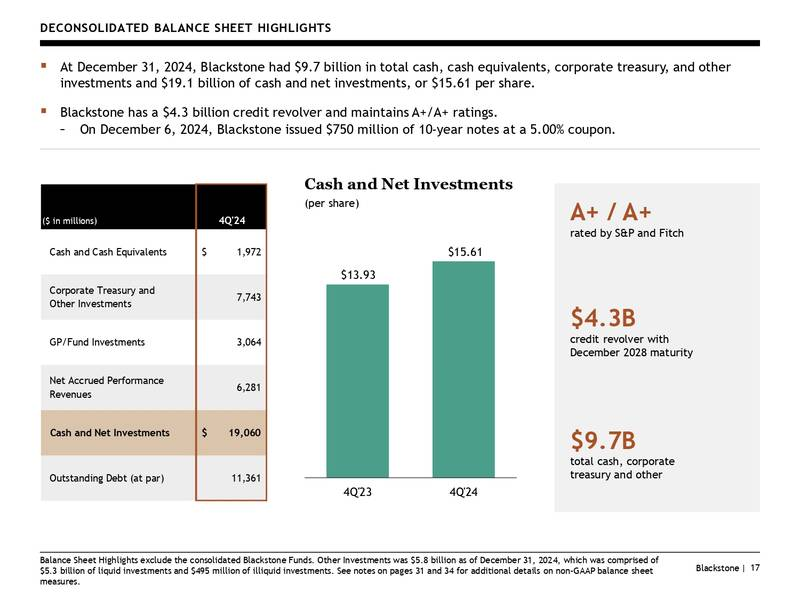

DECONSOLIDATED BALANCE SHEET HIGHLIGHTS

*   At December 31, 2024, Blackstone had $9.7 billion in total cash, cash equivalents, corporate treasury, and other investments and $19.1 billion of cash and net investments, or $15.61 per share.
*   Blackstone has a $4.3 billion credit revolver and maintains A+/A+ ratings.
    -   On December 6, 2024, Blackstone issued $750 million of 10-year notes at a 5.00% coupon.

<table>
  <tr>
    <td>($ in millions)</td>
    <td>4Q'24</td>
  </tr>
  <tr>
    <td>Cash and Cash Equivalents</td>
    <td>$ 1,972</td>
  </tr>
  <tr>
    <td>Corporate Treasury and Other Investments</td>
    <td>7,743</td>
  </tr>
  <tr>
    <td>GP/Fund Investments</td>
    <td>3,064</td>
  </tr>
  <tr>
    <td>Net Accrued Performance Revenues</td>
    <td>6,281</td>
  </tr>
  <tr>
    <td>Cash and Net Investments</td>
    <td>$ 19,060</td>
  </tr>
  <tr>
    <td>Outstanding Debt (at par)</td>
    <td>11,361</td>
  </tr>
</table>

**Cash and Net Investments**
(per share)

<img

In [15]:
image_path = "/teamspace/studios/this_studio/pdf_files_pages/Blackstone4Q24EarningsPressRelease_page-0021.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)
display_text_with_pdf_or_image_plain(
    result,
    image_path
)

## **Example n°6**

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



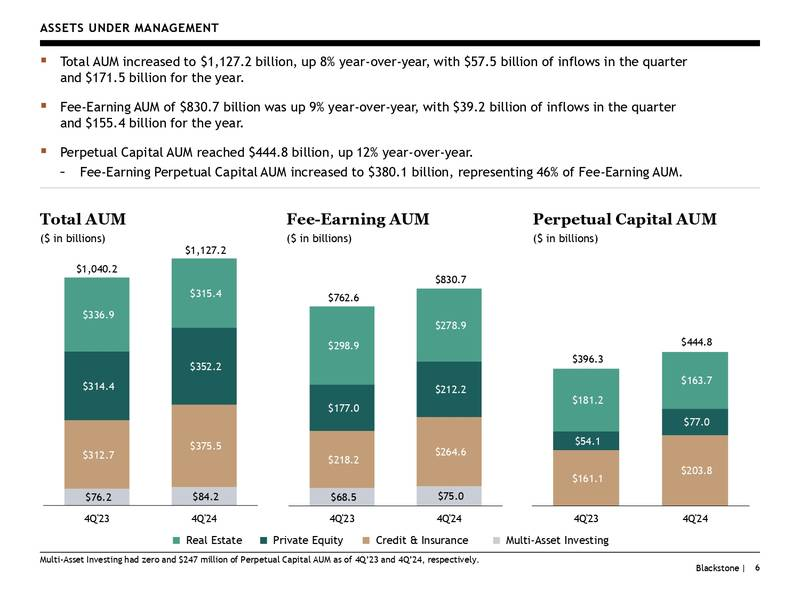

ASSETS UNDER MANAGEMENT

*   Total AUM increased to $1,127.2 billion, up 8% year-over-year, with $57.5 billion of inflows in the quarter and $171.5 billion for the year.
*   Fee-Earning AUM of $830.7 billion was up 9% year-over-year, with $39.2 billion of inflows in the quarter and $155.4 billion for the year.
*   Perpetual Capital AUM reached $444.8 billion, up 12% year-over-year.
    -   Fee-Earning Perpetual Capital AUM increased to $380.1 billion, representing 46% of Fee-Earning AUM.

**Total AUM**
($ in billions)

<img>
A stacked bar chart showing Total AUM ($ in billions) for 4Q'23 and 4Q'24.
- The x-axis shows 4Q'23 and 4Q'24.
- The y-axis shows Total AUM in billions.
- The Total AUM values are:
  - 4Q'23: $1,040.2
  - 4Q'24: $1,127.2
- The bars are divided into four segments:
  - Real Estate: $336.9
  - Private Equity: $315.4
  - Credit & Insurance: $314.4
  - Multi-Asset Investing: $76.2
- The breakdowns for 4Q'24 are:
  - Real Estate: $352.2
  - Private Equity: $762.6
  - Cre

In [16]:
image_path = "/teamspace/studios/this_studio/pdf_files_pages/Blackstone4Q24EarningsPressRelease_page-0010.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)
display_text_with_pdf_or_image_plain(
    result,
    image_path
)

## **Example n°7**

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



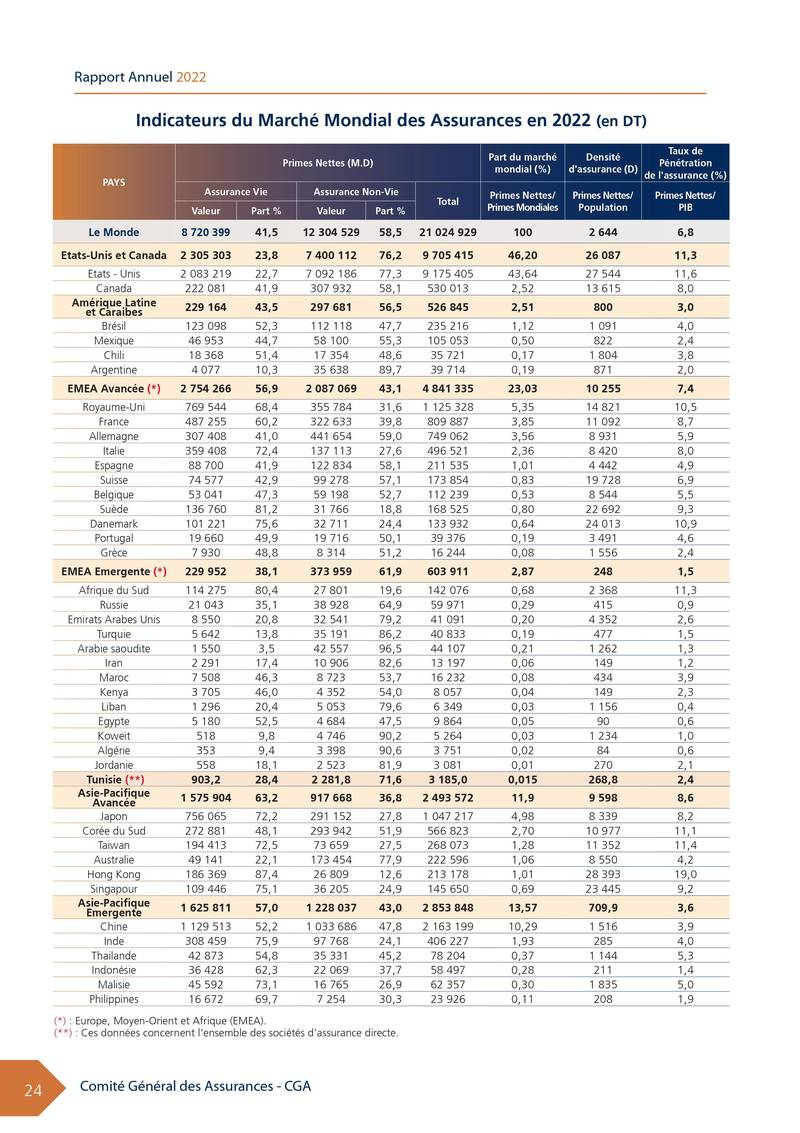

Rapport Annuel 2022

# Indicateurs du Marché Mondial des Assurances en 2022 (en DT)

<table>
  <thead>
    <tr>
      <th rowspan="3">PAYS</th>
      <th colspan="4">Primes Nettes (M.D)</th>
      <th rowspan="3">Total</th>
      <th>Part du marché mondial (%)</th>
      <th>Densité d'assurance (D)</th>
      <th>Taux de Pénétration de l'assurance (%)</th>
    </tr>
    <tr>
      <th colspan="2">Assurance Vie</th>
      <th colspan="2">Assurance Non-Vie</th>
    </tr>
    <tr>
      <th>Valeur</th>
      <th>Part %</th>
      <th>Valeur</th>
      <th>Part %</th>
    </tr>
    <tr>
      <th>Le Monde</th>
      <td>8 720 399</td>
      <td>41,5</td>
      <td>12 304 529</td>
      <td>58,5</td>
      <td>21 024 929</td>
      <td>100</td>
      <td>2 644</td>
      <td>6,8</td>
    </tr>
    <tr>
      <td rowspan="2">Etats-Unis et Canada</td>
      <td rowspan="2">2 305 303</td>
      <td rowspan="2">23,8</td>
      <td rowspan="2">7 400 112</td>
      <td rowspan="2">76,2</td>
     

In [17]:
image_path = "/teamspace/studios/this_studio/Different_Tables_Images_Testing/other_table.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)
display_text_with_pdf_or_image_plain(
    result,
    image_path
)

## **Example n°8**

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



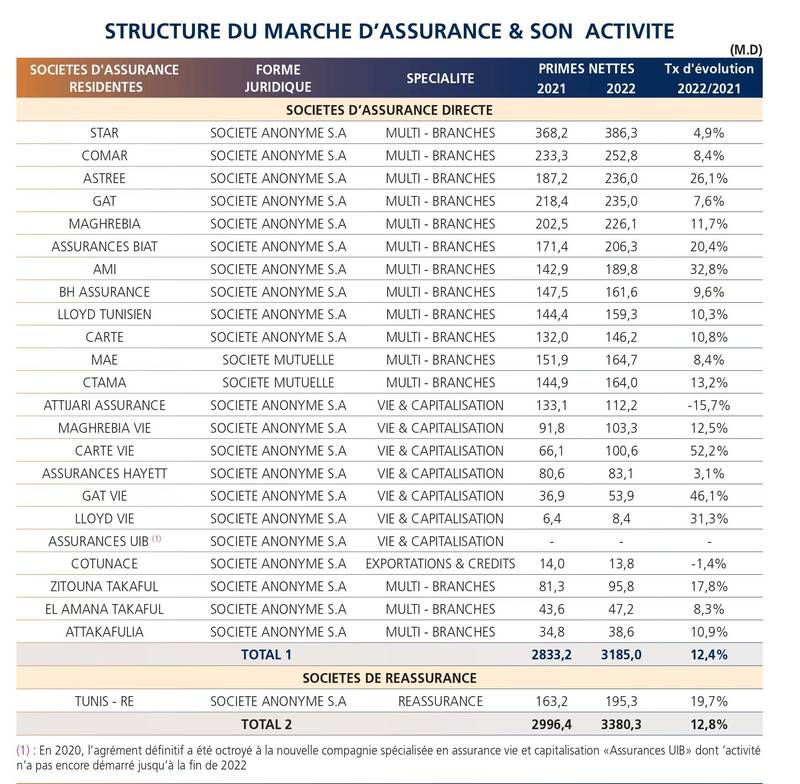

**STRUCTURE DU MARCHE D'ASSURANCE & SON ACTIVITE**

(M.D)

<table>
  <tr>
    <td>SOCIETES D'ASSURANCE RESIDENTES</td>
    <td>FORME JURIDIQUE</td>
    <td>SPECIALITE</td>
    <td colspan="2">PRIMES NETTES</td>
    <td>Tx d'évolution</td>
  </tr>
  <tr>
    <td colspan="6" style="background-color: #F0E6E6;">SOCIETES D'ASSURANCE DIRECTE</td>
  </tr>
  <tr>
    <td>STAR</td>
    <td>SOCIETE ANONYME S.A</td>
    <td>MULTI - BRANCHES</td>
    <td>368,2</td>
    <td>386,3</td>
    <td>4,9%</td>
  </tr>
  <tr>
    <td>COMAR</td>
    <td>SOCIETE ANONYME S.A</td>
    <td>MULTI - BRANCHES</td>
    <td>233,3</td>
    <td>252,8</td>
    <td>8,4%</td>
  </tr>
  <tr>
    <td>ASTREE</td>
    <td>SOCIETE ANONYME S.A</td>
    <td>MULTI - BRANCHES</td>
    <td>187,2</td>
    <td>236,0</td>
    <td>26,1%</td>
  </tr>
  <tr>
    <td>GAT</td>
    <td>SOCIETE ANONYME S.A</td>
    <td>MULTI - BRANCHES</td>
    <td>218,4</td>
    <td>235,0</td>
    <td>7,6%</td>
  </tr>
  <tr>
    <td>MAGHREBIA</td>
    <td>

In [18]:
image_path = "/teamspace/studios/this_studio/Different_Tables_Images_Testing/other_table_big.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)
display_text_with_pdf_or_image_plain(
    result,
    image_path
)

## **Example n°9**

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



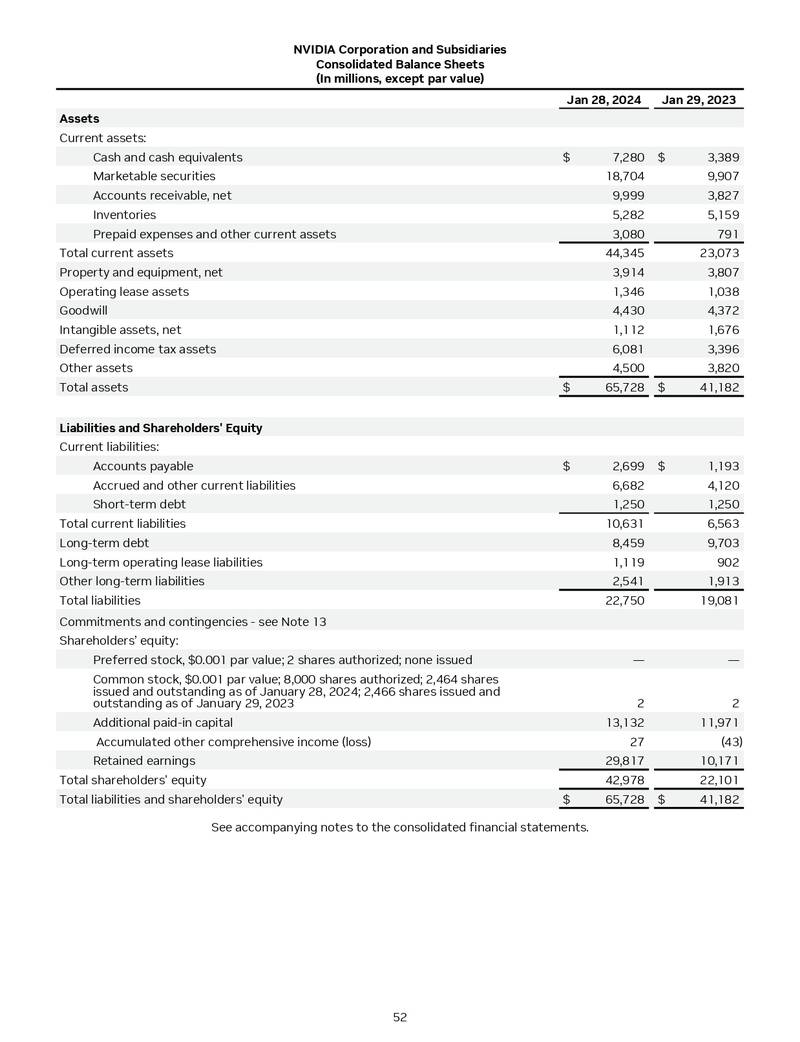

**NVIDIA Corporation and Subsidiaries**
**Consolidated Balance Sheets**
**(In millions, except par value)**
----------------------------------------


,**Assets**,"**Jan 28, 2024**","**Jan 29, 2023**"
0,Current assets:,,
1,Cash and cash equivalents,"7,280","3,389"
2,Marketable securities,"18,704","9,907"
3,"Accounts receivable, net","9,999","3,827"
4,Inventories,"5,282","5,159"
5,Prepaid expenses and other current assets,"3,080",791
6,Total current assets,"44,345","23,073"
7,"Property and equipment, net","3,914","3,807"
8,Operating lease assets,"1,346","1,038"
9,Goodwill,"4,430","4,372"


See accompanying notes to the consolidated financial statements.

<page_number>52</page_number>


In [19]:
image_path = "/teamspace/studios/this_studio/Different_Tables_Images_Testing/NVIDIA_Report_Removed_Pages-1-16-14_page-0001.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)
display_text_with_pdf_or_image_plain(
    result,
    image_path
)

## **Example n°10**

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



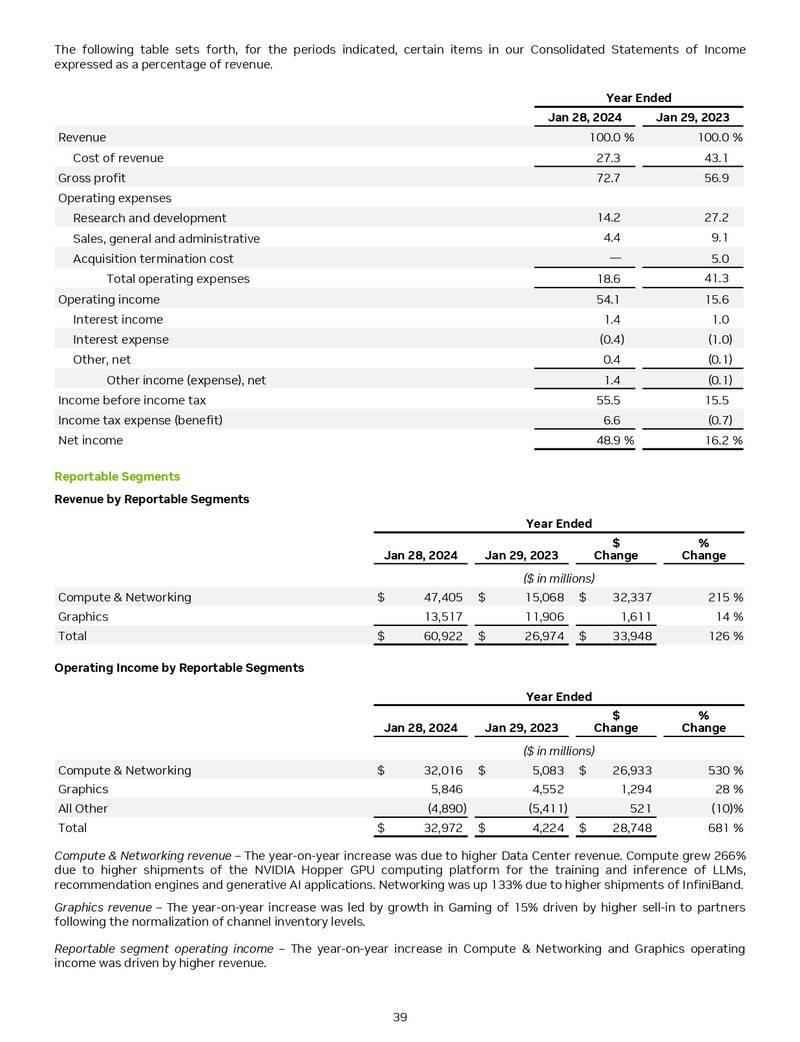

The following table sets forth, for the periods indicated, certain items in our Consolidated Statements of Income expressed as a percentage of revenue.
----------------------------------------
[Could not parse table]
|  | Year Ended |
|---|---|
| **Jan 28, 2024** | **Jan 29, 2023** |
| Revenue | 100.0 % | 100.0 % |
| Cost of revenue | 27.3 | 43.1 |
| Gross profit | 72.7 | 56.9 |
| Operating expenses |  |  |
| Research and development | 14.2 | 27.2 |
| Sales, general and administrative | 4.4 | 9.1 |
| Acquisition termination cost | — | 5.0 |
| Total operating expenses | 18.6 | 41.3 |
| Operating income | 54.1 | 15.6 |
| Interest income | 1.4 | 1.0 |
| Interest expense | (0.4) | (1.0) |
| Other, net | 0.4 | (0.1) |
| Other income (expense), net | 1.4 | (0.1) |
| Income before income tax | 55.5 | 15.5 |
| Income tax expense (benefit) | 6.6 | (0.7) |
| Net income | 48.9 % | 16.2 % |


**Reportable Segments**

**Revenue by Reportable Segments**
----------------------------------------


,,Year Ended ****
0,,**%**


**Operating Income by Reportable Segments**
----------------------------------------


,,Year Ended ****
0,,**%**


*Compute & Networking revenue* – The year-on-year increase was due to higher Data Center revenue. Compute grew 266% due to higher shipments of the NVIDIA Hopper GPU computing platform for the training and inference of LLMs, recommendation engines and generative AI applications. Networking was up 133% due to higher shipments of InfiniBand.

*Graphics revenue* – The year-on-year increase was led by growth in Gaming of 15% driven by higher sell-in to partners following the normalization of channel inventory levels.

*Reportable segment operating income* – The year-on-year increase in Compute & Networking and Graphics operating income was driven by higher revenue.


In [20]:
image_path = "/teamspace/studios/this_studio/Different_Tables_Images_Testing/NVIDIA_Report_Removed_Pages-1-16-9_page-0001.jpg"
result = ocr_page_with_nanonets_s(image_path, model, processor, max_new_tokens=15000)
display_text_with_pdf_or_image_plain(
    result,
    image_path
)